In [1]:
import pandas as pd
from utils import read_data, categorical_features
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from time import time
from typing import List
import warnings
import optuna
from optuna.samplers import TPESampler
from dython.nominal import associations

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
plt.rcParams.update({'font.size': 12})

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")  # silences 'numba.jit' decoder error
import shap

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Our task

In this activity, we're asked to "[look] for accident / fatality risk factors, and [provide] an understanding of the factors that contribute to accidents and the severity of accidents." Examples include location, time of day, weather, road surfaces, etc. To answer these questions we are to use road accident and safety data from Great Britain, which can be found [here](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data). We're to create a Jupyter Notebook presenting these findings, communicating these suggested improvements to the Department of Transport. Additionally, if we're able, we are to provide information to car manufacturers to improve their products.

# Modeling strategy

Implicitly, this asks us to create a causal model of the factors leading to an accident or fatality. However, **we lack a plausible exogenous source of variation from which a causal effect could be identified** (for more, [see](https://en.wikipedia.org/wiki/Endogeneity_(econometrics))). For this reason I interpret model results as **correlational, not causal**.

This task is also distinctly different from classical machine learning modeling efforts, where **prediction** is chiefly of interest. **Rather, we are interested in model coefficients** à la regression analysis. 

To satisfy this task, I take a somewhat different approach using a machine learning model ([light gradient boosted machines or LGBM](https://lightgbm.readthedocs.io/en/stable/)) combined with an explanation algorithm, [SHapley Additive exPlanations or SHAP](https://shap.readthedocs.io/en/latest/). 

Compared to traditional regression analysis, where the analyst must a-priori specify the structural causal model, this ML model more flexibly models the outcome variable, enabling it to better align with the population data generating process. SHAP values explain or "credit" the model's prediction to the features included in the model, thereby not only demystifying the traditional "black-box" nature of ML, but also offering an analygous concept to a regression coefficient. Rather than offering a "global" explanation of which features were important to the model as a whole (e.g. XGBoost's `get_scores` method), **SHAP values quantify the effect of features on an individual observation's prediction**, enabling e.g. highly detailed subgroup analysis.

### Model interpretation

The outcome variable I use (see below) **explicitly models the severity of the accident for a given vehicle, examining which features matter most in predicting this severity. In our case "severity" is a binary indicator whether an accident yielded no/slight injuries versus severe/fatal injuries**.

# 1.0 Data

I use data from the most recent three years (2019 - 2021). By including the year 2019, I hope to somewhat offset the irregular traffic and commuting patterns caused by the Corona virus. Older years of data, going back to 1979. are available; however, I prefer to use only newer data in order to examine accident/fatality factors among newer vehicles.

These **data are hierarchical in nature**, presenting some initial modeling and data challenges in their raw form. There are **three distinct entities** and corresponding datasets: **accidents** (i.e. general information where, when, and why), **vehicles** (i.e. cars, vans, buses, trollies, bicycles, and other [horses, farm tractors] involved in an accident), and **casualties** (i.e. within a particular vehicle but also potentially pedestrians struck by a vehicle). Casualties are nested within vehicles, which in turn are nested within accidents. 

### 1.1 Data preprocessing

I use **vehicles as the level of analysis**, aggregating casualty information up to the vehicle level (e.g. total casualties, mean age of casualties, share male) and merge this onto the vehicle file. In a final step, I merge the accident data onto the vehicle file. 

Because substantial data preprocessing was required, I outsourced this several functions in `utils.py`. In addition to data restructuring, I drop several features that I suspect have no causal effect on the outcome, recode unknown category values to missing, engineer some new datetime features, consolidate the number of distinct vehicle types from 22 to 9. 

Importantly, **some vehicles involved in an accident have no casualties** (i.e. they have no match in the casualty dataset). I include these vehicles in the analysis by way of creating a new class of casualty severity, "non-injury" in the outcome variable. (see below).

### 1.2 Outcome feature

**I create a new binary outcome feature, `casualty_worst`, which represents the *worst casualty* attributed to a particular vehicle in a particular accident**. Casualties can partain to vehicle occupants or pedestrians struck by the vehicle (bicycles are also counted as vehicles). **This feature does not differentiate between the number of casualties associated with a vehicle**. I use this new outcome feature in all modeling efforts below.

To create this new outcome feature I start with the the feature, `casualty_severity`, in the casualty dataset, which contains three classes of casualty severity: "slight", "severe", or "fatal". **I combine "non-injury" vehicles (see above) with slight injury vehicles as the baseline class (=0). I also combine "serious" and "fatal" together as the other class (=1)**. Combining casualty classes in this way simplifies the analytic step I take below, and also strongly bolsters the frequency of the class coded 1 since fatalities are extremely rare in the data.

This new outcome is coded as such:

0) **non-injury*** or slight injury
1) serious injury or fatality

\* New category, created for vehicles in an accident with no casualties

### 1.3 Predictors of accident severity in data

The processed data contain 43 feature, of which I use 42 for model prediction (the other being the outcome). Grouping these predictive features by their instrumental type:

- Vehicle attributes
    - `vehicle_type`: type of vehicle driven, e.g. bicycle, car, motorcycle, bus, trolly, goods vehicle
    - `vehicle_left_hand_drive`: bool for whether a vehicle is left-hand-drive or right-hand-drive
    - `engine_capacity_cc`: size of vehicle engine in cubic centimenters
    - `age_of_vehicle`: age of vehicle in years
    - `propulsion_code`: code for vehicle's propulsion means, e.g. gas, diesel, electric, hybrid
    - `towing_and_articulation`: type of trailer towing or if vehicle articulates


<br />

- Accident attributes
    - `vehicle_manoeuvre`: what the vehicle was doing at time of the accident, e.g. turning, breaking, waiting
    - `vehicle_leaving_carriageway`: direction vehicle was heading as it was leaving the carriageway, e.g. offside, nearside, straight
    - `hit_object_off_carriageway`: code for if vehicle hit something off the carriageway and what, e.g. tree
    - `hit_object_in_carriageway`: code for if vehicle hit something in the carriageway and what, e.g. kerb, parked car, previous accident, bridge, open door
    - `skidding_and_overturning`: whether vehicle skidded, overturned, jackknifed
    - `first_point_of_impact`: location on vehicle first impacted, e.g. front, back, driver's side
    - `vehicle_location_restricted_lane`: not in restricted lane, tramway, bus lane, cycle lane, etc.
    - `road_surface_conditions`: dry, wet, snow, ice, oil/diesel, mud
    - `weather_conditions`: fine/no winds, raining no high winds, snowing no high winds, fine + high winds, raining + high winds, etc.
    - `light_conditions`: daylight, darkeness w/headlights, darkness wo/headlights, darkness no lights
    - `special_conditions_at_site`: none, traffic signal out, roadwork, road sign obscured, mud, oil/diesel
    - `carriageway_hazards`: object on road, animal on road, pedestrian in carriageway (not injured)
    - `number_of_vehicles`: number of vehicles involved in accident
    - `speed_limit`: speed limit on carriageway
    - `casualty_share_male`: proportion of casualties struck by vehicle that are male (versus female). For identification, vehicles with no casualties receive global mean value
    - `casualty_mean_age`: mean age of casualties struck by vehicle in years. For identification, vehicles with no casualties receive global mean value
    - `casualty_modal_type`: modal type of casualty struck by vehicle, e.g. pedestrian, bike, car, bus, trolly. For identification, vehicles with no casualties receive global modal value
    - `casualty_total`: total number of casualties in accident across all vehicles

<br />

- Location of accident
    - `road_type`: type of road, e.g. roundabout, crossroad, private drive, T-junction
    - `junction_location`: distance from road junction, e.g. mid-junction, leaving roundabout, entering roundabout, entering main road
    - `junction_control`: type of control mechanism e.g. stop sign, traffic signal, authorized person
    - `urban_or_rural_area`: urban or rural
    - `latitude`: latitude
    - `longitude`: longitude
    - `local_authority_district`: geographic code for local authority of accident area

<br />

- Date & time of accident
    - `accident_year`: numeric year, ranging from 2019-2021
    - `month`: numeric calendar month
    - `day`: calendar day of month
    - `dayw`: numeric day of week, range 0-6
    - `hour`: numeric hour based on 24-hour clock
    - `elapsed_time`: time in seconds since the first recorded accident timestamp in data selection

<br />
    
- Driver attributes
    - `sex_of_driver`: driver's sex, e.g. male, female or missing
    - `age_of_driver`: numeric age in years
    - `driver_imd_decile`: relative deprivation/poverty of driver's home area
    - `driver_home_area_type`: urban, small town, rural
    - `journey_purpose_of_driver`: commuting to work, journey as part of work, taking pupil to school, other, not known


### 1.4 Read data, summary stats

In [2]:
current = time()
df = read_data()
print(f"Total data read & preprocessing time: {round(time() - current, 2)} seconds.")

Total data read & preprocessing time: 130.36 seconds.


In [3]:
print(df.casualty_worst.value_counts().sort_index())
print('\n', df.casualty_worst.value_counts(normalize=True).sort_index())

0    500841
1     69332
Name: casualty_worst, dtype: int64

 0    0.878402
1    0.121598
Name: casualty_worst, dtype: float64


In [4]:
df.head()

,vehicle_type,casualty_modal_type,towing_and_articulation,vehicle_manoeuvre,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,vehicle_location_restricted_lane,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,propulsion_code,driver_imd_decile,driver_home_area_type,local_authority_district,road_type,junction_control,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,accident_year,month,day,dayw,hour,elapsed_time,age_of_driver,engine_capacity_cc,age_of_vehicle,casualty_share_male,casualty_mean_age,longitude,latitude,number_of_vehicles,speed_limit,casualty_total,casualty_worst
0,9.0,9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1,2019,2,18,0,17,4211040.0,58.0,NaN,NaN,0.333333,18.666667,-0.153842,51.508057,2,30.0,0.0,0
1,9.0,9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1,2019,2,18,0,17,4211040.0,NaN,NaN,NaN,0.609270,37.746357,-0.153842,51.508057,2,30.0,0.0,0
2,9.0,9,0.0,18.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN,3.0,1.0,9.0,2.0,NaN,4.0,1.0,1.0,0.0,0.0,1,2019,1,15,1,21,1287540.0,24.0,NaN,NaN,0.000000,24.000000,-0.127949,51.436208,2,30.0,0.0,0
3,9.0,9,0.0,18.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,9.0,2.0,NaN,4.0,1.0,1.0,0.0,0.0,1,2019,1,15,1,21,1287540.0,NaN,NaN,NaN,0.609270,37.746357,-0.127949,51.436208,2,30.0,0.0,0
4,9.0,9,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,NaN,4.0,1.0,2.0,6.0,4.0,4.0,1.0,1.0,0.0,0.0,1,2019,1,1,1,1,6240.0,45.0,NaN,NaN,0.609270,37.746357,-0.124193,51.526795,2,30.0,0.0,0


In [5]:
df.shape

(570173, 43)

In [6]:
df_summary = df.isnull().mean()
df_summary = pd.concat([df_summary, df.dtypes], axis=1)
df_summary.rename(columns={0: 'share_missing', 1: 'dtype'})

,share_missing,dtype
vehicle_type,0.000631,category
casualty_modal_type,0.000000,category
towing_and_articulation,0.024428,category
vehicle_manoeuvre,0.075167,category
junction_location,0.055402,category
skidding_and_overturning,0.075931,category
hit_object_in_carriageway,0.074456,category
vehicle_leaving_carriageway,0.073516,category
vehicle_location_restricted_lane,0.072962,category
hit_object_off_carriageway,0.069977,category


# 2.0 Exploratory data analysis (EDA)

### 2.1 Number of serious & non-serious accidents by year

In [7]:
acc_yr = df.groupby('accident_year')['casualty_worst'].value_counts().rename('total').reset_index()

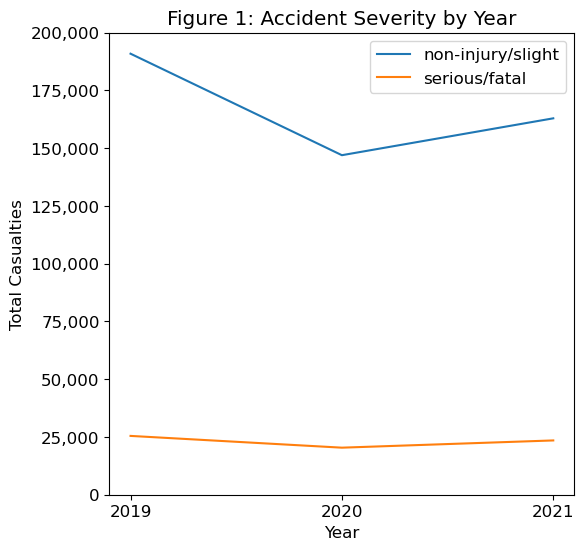

In [8]:
plt.figure(figsize=(6,6))
acc_yr_0 = acc_yr[acc_yr['casualty_worst']==0]
acc_yr_1 = acc_yr[acc_yr['casualty_worst']==1]
ax = sns.lineplot(acc_yr_0, x='accident_year', y='total', label='non-injury/slight')
ax = sns.lineplot(acc_yr_1, x='accident_year', y='total', label='serious/fatal')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.ylim(0, 200_000)
plt.ylabel('Total Casualties')
plt.xlabel('Year')
plt.xticks(range(2019, 2022))
plt.title("Figure 1: Accident Severity by Year")
plt.show()

### 2.2 Associations between features

The following heatmap shows the relationship between each feature in `df` and all other features. The measurement of this relationship depends on the type of pair of data types:
- continuous-continous: [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
- categorical-continous: [correlation ratio](https://en.wikipedia.org/wiki/Correlation_ratio)
- categorical-categorical: [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

In [9]:
corr = associations(df, nan_strategy='drop_sample_pairs', figsize=(20, 20), annot=False, multiprocessing=True, plot=False)

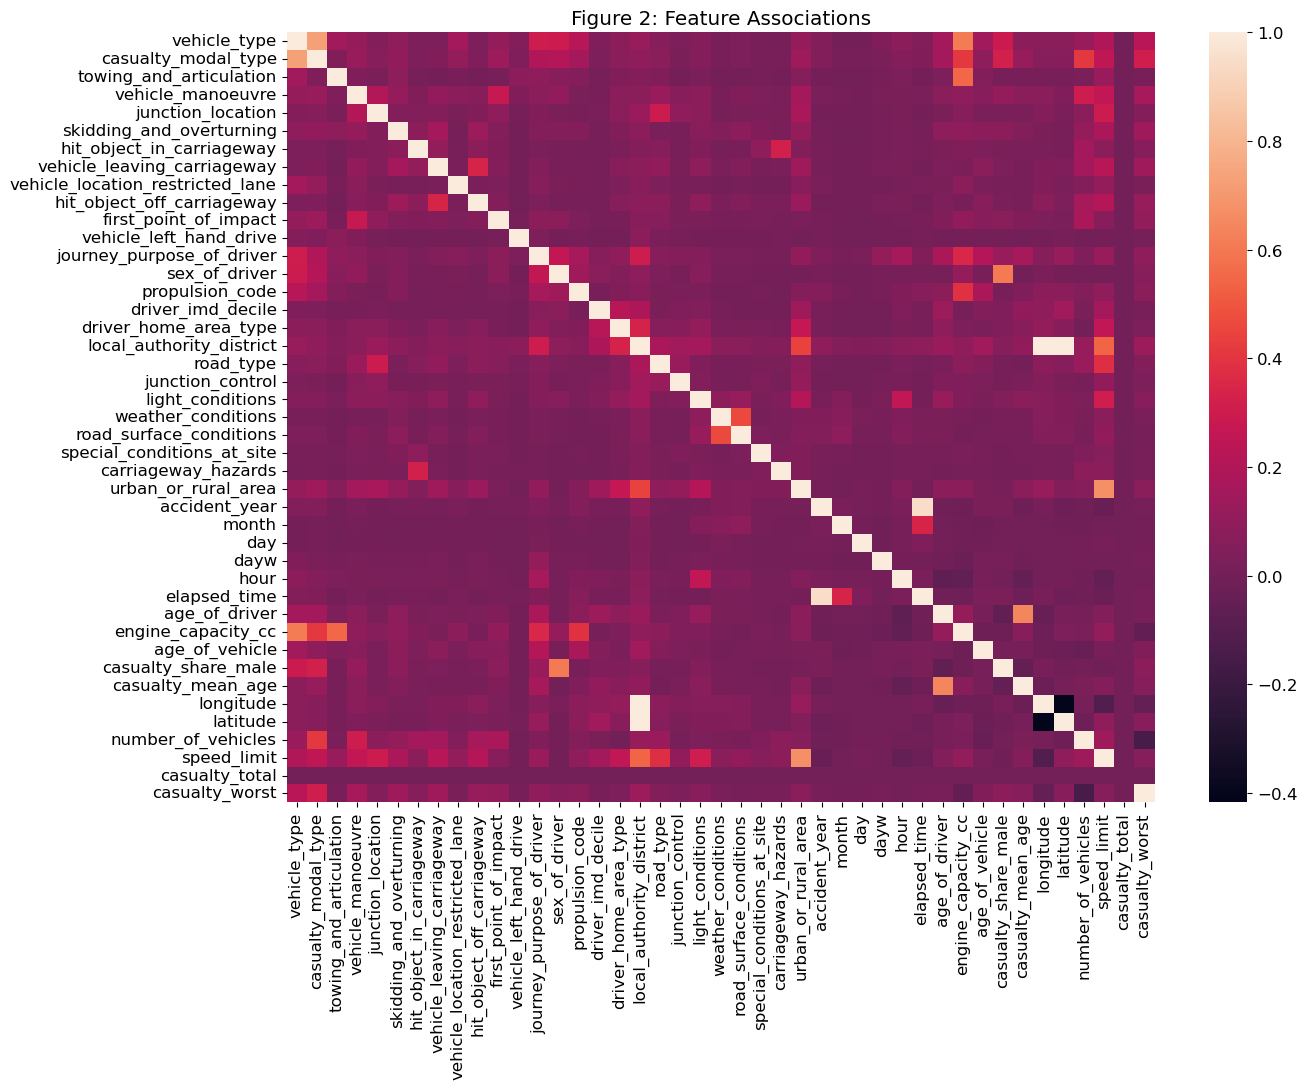

In [10]:
plt.figure(figsize=(14,10))
sns.heatmap(corr['corr'])
plt.title('Figure 2: Feature Associations')
plt.show()

# 3.0 ML Model

LightGBM is a gradient boosting framework that uses tree based learning algorithms for raking, classiciation, and regression. Importantly, LightGBM differs from other gradient boosted decision tree frameworks (e.g. XGBoost) in that trees are grown leaf-wise, rather than level-wise. 

LightGBM importantly needs to know which features are categorical versus numeric. In earlier preprocessing stages we ensured categorical features had numeric representations (a requirement of LGBM) and cast these as 'category' types in Pandas.

#### A note on feature normalization

[Feature normalization](https://en.wikipedia.org/wiki/Feature_scaling) (e.g. min-max normalization or z-score standardization) is a common practice for many ML models. Generally, this practice speeds up and stabilizes model training. However, **this data transformation is not required for tree-based models such as the one I'm using**. The reason is because tree-based models do not care about the absolute values of a feature, only the order of the values.

### 3.1 Cross-validation using stratified holdout method

I use a traditional cross-validation holdout strategy to help me: 1) find the optimal model hyperparameters; and 2) guard against overfitting to the training set. Logically, one might ask why we'd worry about overfitting for this particular task, especially considering these data represent the universe of vehicle accident information in the period. However, one might counter that these data are simply one realization of an unknown population "superset". Either way, combating overfitting is useful to learn the general properties of the data generating process and not just a particular instance of data.

I use a 20% stratified holdout set to evaluate the hyperparameters of a given model trial (see below). I prefer a simple holdout set for sake of time and simplicity over e.g. stratified k-fold cross-validation, though such a cross-validation strategy would be potentially worth considering given more time.

In [12]:
prediction_features = [i for i in df.columns if "casualty_worst" not in i]
X_train, X_val, y_train, y_val = train_test_split(df[prediction_features], 
                                                    df['casualty_worst'],
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=df['casualty_worst'],
                                                    shuffle=True)

In [13]:
print(X_train.shape)
print(X_val.shape)

print('\n', y_train.mean())
print(y_val.mean())

(456138, 42)
(114035, 42)

 0.12159916516492816
0.1215942473801903


### 3.2 Model hyperoptimization using `Optuna`

Our strategy to identify the factors predicting the severity of a vehicular accident requires that we accurately model the data generating process. To ensure our model fits the data well, I use a hyperperameter optimization framework called `Optuna`.

Optuna is an automatic hyperparameter optimization framework. It offers several optimization algorithms including grid and random search. We stick with the default [TPE (Tree-structured Parzen Estimator)](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) algorithm.

The optimizer below seeks to find the best hyperparameter combination, where "best" is defined as the trial with the lowest binary log-loss in the validation set for that trial.

I hyperoptimize parameters that are well understood to have a strong effect on model performance, using common search values (these were also suggested by Optuna for LGBM).

In [14]:
def objective(trial: optuna.Trial, X_train: pd.DataFrame, X_val: pd.DataFrame, 
              y_train: pd.Series, y_val: pd.Series) -> float:
    """
    Wrapper function for optuna hyperparameter optimization. 
    :param X_train: pd.DataFrame, training predictors
    :param X_val: pd.DataFrame, validation predictors
    :param y_train: pd.Series, training target
    :param y_val: pd.Series, validation target
    :return: float, binary log-loss from trial
    """
    
    # Note - LGBM seems to prefer dataset instantiation per trial, else generates errors
    train = lgb.Dataset(data=X_train,
                    label=y_train,
                    free_raw_data=False)

    validation = lgb.Dataset(data=X_val,
                             label=y_val,
                             free_raw_data=False)
    
    # Hyperparameters to search
    params = {
        "objective": "binary",
        "metric": ["binary_logloss"],
        "verbose": -1,
        "early_stopping_round": 5,
        "boosting_type": "gbdt",
        "num_threads": 8,
        "seed": 123,
        "num_iterations": 100,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(params, train, valid_sets=[validation],
                    verbose_eval=False, keep_training_booster=True)

    loss = gbm.eval_valid()[0][2]  # binary log-loss from validation set in this trial

    return loss

In [15]:
current = time()

sampler = TPESampler(seed=10)  # ensures reproducibility
study = optuna.create_study(sampler=sampler, direction='minimize')  # note - uses median pruner by default
study.optimize(lambda trial: objective(trial, X_train, X_val, y_train, y_val), n_trials=50)

print(f"Total model hyperoptimization time: {round(time() - current, 2)} seconds. \n")

print("Number of finished trials: {}".format(len(study.trials)))

print(f"Best trial number {study.best_trial.number}")

print("Best parameters:")
best_parameters = study.best_trial.params
best_parameters

Total model hyperoptimization time: 204.32 seconds. 

Number of finished trials: 50
Best trial number 31
Best parameters:


{'lambda_l1': 0.5396676065731045,
 'lambda_l2': 0.004407348033355316,
 'num_leaves': 112,
 'feature_fraction': 0.4450067164339832,
 'bagging_fraction': 0.9846330606708291,
 'bagging_freq': 5,
 'min_child_samples': 28}

### 3.3 Model training using best hyperparameters

Now that we have learned the optimal hyperparameters from above, we plug this into our actual model.

In [16]:
train = lgb.Dataset(data=X_train,
                    label=y_train,
                    free_raw_data=False)

validation = lgb.Dataset(data=X_val,
                         label=y_val,
                         free_raw_data=False)

In [17]:
# Combine best hyperparameters with other necessary model params
params = {
        "objective": "binary",
        "metric": ["binary_logloss", 'auc'],
        "verbose": -1,
        "early_stopping_round": 5,
        "boosting_type": "gbdt",
        "num_threads": 4,
        "seed": 123,
}

params = dict(params, **best_parameters)

In [18]:
current = time()

results = {}
bst = lgb.train(params, train, valid_sets=[validation],
                evals_result=results, verbose_eval=False)

print(f"Total model training time: {round(time() - current, 2)} seconds.")

Total model training time: 5.67 seconds.


### 3.4 Model performance in holdout using best hyperparameters

Figure 1 depicts the loss function, [binary cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) in the validation set by epoch. We can see the loss continue to decrease until training was halted due to early stopping.

In order to understand Figure 2, AUC, it's necessary to first understand the [receiver operator characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). The ROC curve is an evaluation metric for binary classication problems, which plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds. Area under the curve (AUC) is a summary measure of the ROC, capturing the area underneath the ROC curve. Figure 2 therefore represents AUC scores in the validation set across epochs.

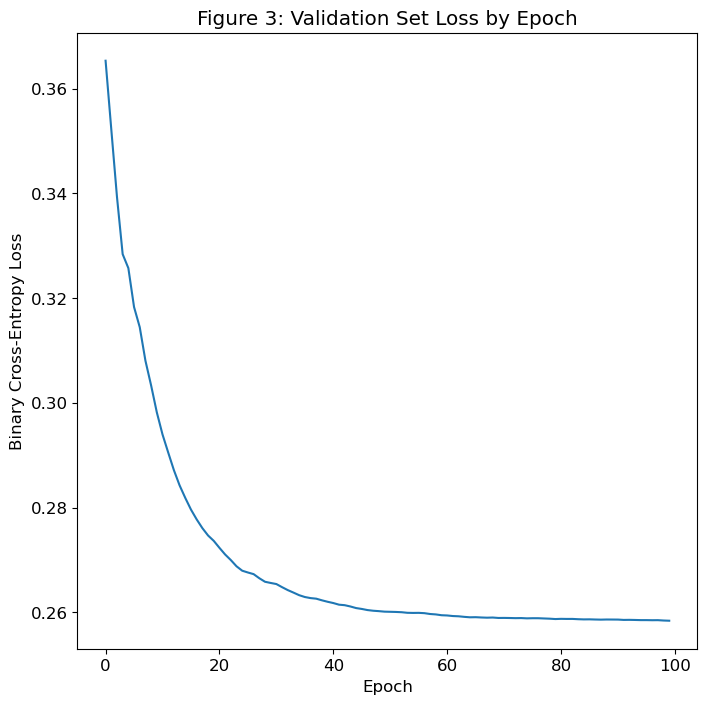

In [19]:
plt.figure(figsize=(8,8))
plt.plot(results['valid_0']['binary_logloss'])
plt.title('Figure 3: Validation Set Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

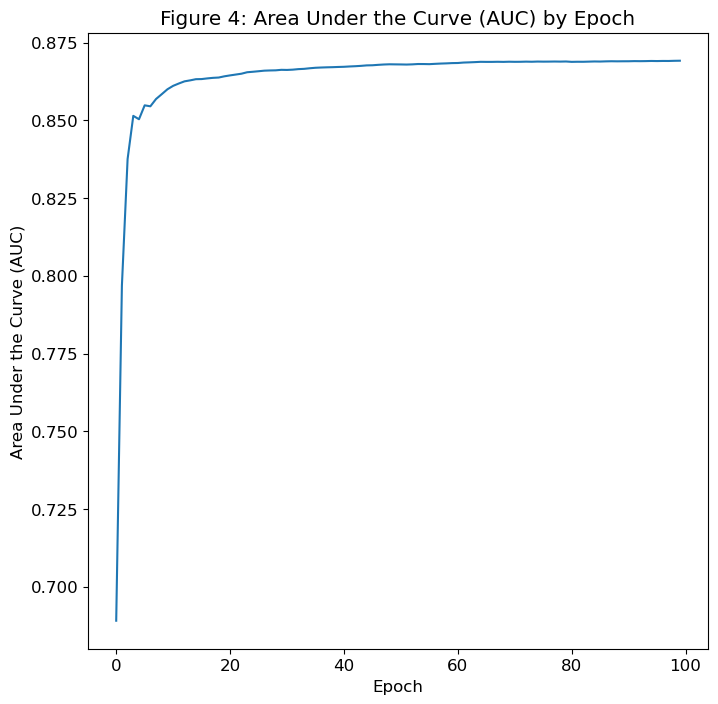

In [20]:
plt.figure(figsize=(8,8))
plt.plot(results['valid_0']['auc'])
plt.title('Figure 4: Area Under the Curve (AUC) by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Area Under the Curve (AUC)')
plt.show()

# 4.0 SHAP values

Intuitively, Shapley values are calculated by comparing a model prediction with and without each feature. However, the contributions of the features depend on the order in which they are omitted from the model. One method to address this issue would be to compute predictions for all possible orders of omitted features. In general, however, this method is computationally intractable. SHAP’s TreeExplainer method calculates exact Shapley values by utilizing the internal structure of tree-based models, measuring the effects of features based on a set of calculations for each leaf in a tree ([source](https://www.nature.com/articles/s42256-019-0138-9)).

**By the term “contribution,” I mean that SHAP values quantify each feature’s effect on the change in model prediction for each observation (i.e., a partial effect from the mean of the prediction in the test set). Averaging individuals’ SHAP values by feature, the reported SHAP values represent average partial effects (i.e., the average contribution of a feature on the outcome, conditional on the other features in the model); these are not average marginal effects (i.e., the average instantaneous change in the outcome in response to an instantaneous change to the value of the feature, conditional on other features in the model)**. 

Because our target feature is binary, SHAP values are symmetric. **SHAP values capture a *change in the log odds of accident severity relative to the baseline*. I.e. positive SHAP values increase a given feature or feature value increases the odds of a severe accident; converse, negative SHAP values decrease the odds of accident severity**. Summing SHAP values across features for a given individual equals that person’s prediction. Individuals missing data for a given feature have a SHAP value of zero.

### 4.1 Calculate SHAP values

In [21]:
explainer = shap.TreeExplainer(bst)

In [22]:
current = time()
shap_values = explainer.shap_values(df[prediction_features])
print(f"Total time to calculate SHAP values: {round(time() - current, 2)} seconds")

Total time to calculate SHAP values: 398.59 seconds


In [23]:
shap_vals = pd.DataFrame(shap_values[1], columns=df[prediction_features].columns, index=df[prediction_features].index)

### 4.2 SHAP summary stats

In [24]:
shap_vals.head()

,vehicle_type,casualty_modal_type,towing_and_articulation,vehicle_manoeuvre,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,vehicle_location_restricted_lane,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,propulsion_code,driver_imd_decile,driver_home_area_type,local_authority_district,road_type,junction_control,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,accident_year,month,day,dayw,hour,elapsed_time,age_of_driver,engine_capacity_cc,age_of_vehicle,casualty_share_male,casualty_mean_age,longitude,latitude,number_of_vehicles,speed_limit,casualty_total
0,-0.105439,-0.276782,-0.020703,-0.260365,-0.171051,-0.051929,-0.059848,-0.030509,-0.016403,-0.057326,-0.123702,-0.225359,-0.004563,0.009981,0.035375,-0.037294,0.006220,0.053529,-0.045398,-0.012444,-0.010155,0.014350,-0.001272,-0.001401,-0.003915,-0.055609,-0.002291,0.009973,-0.000585,-0.013732,-0.032532,0.016295,0.055690,0.054717,0.050425,1.879316,0.579525,-0.008573,-0.141534,-0.111814,-0.127592,0.0
1,-0.116582,-0.574952,-0.012696,-0.169667,-0.119011,-0.052609,0.003895,0.000582,-0.016295,-0.023863,-0.066892,-0.202884,-0.002761,0.003419,0.055398,-0.026845,0.007841,0.041190,0.007308,-0.010474,-0.008079,0.007553,-0.000966,-0.003110,-0.004338,-0.050771,-0.004332,-0.003103,-0.000436,-0.014260,-0.017478,-0.036866,-0.160983,0.038664,0.034247,-1.126683,-1.048324,-0.000928,-0.070195,-0.102977,-0.131940,0.0
2,-0.117618,-0.383916,-0.009704,0.109141,0.052020,-0.066469,-0.087922,-0.019151,-0.019413,-0.081856,0.135026,-0.300021,0.000224,-0.022692,0.038347,-0.032759,0.013391,-0.106036,-0.126166,0.002657,0.027290,0.008319,0.001663,0.000141,-0.006476,-0.059489,-0.001793,-0.003337,0.009631,-0.004892,0.204049,-0.051950,0.038052,0.040504,0.048079,1.041942,0.677474,0.008354,-0.175555,-0.094933,-0.132617,0.0
3,-0.125728,-0.620529,-0.008284,0.063878,0.077350,-0.057658,-0.013692,-0.003071,-0.015375,-0.061533,-0.084135,-0.211414,0.000969,-0.000151,0.064561,0.025101,0.019345,-0.081565,-0.058132,0.002274,0.019877,0.006928,-0.001428,-0.001029,-0.007573,-0.049818,-0.014908,0.000843,0.002112,-0.021225,0.201312,-0.061335,-0.132016,0.031962,0.043241,-1.129907,-1.111999,0.014658,-0.096612,-0.087992,-0.133844,0.0
4,-0.097286,-0.591375,-0.000507,-0.015480,-0.053594,-0.020012,-0.002594,-0.042182,0.001908,-0.000874,-0.157233,0.020493,-0.006433,0.004587,0.079751,0.010143,0.008195,-0.006774,0.006130,-0.001527,0.031863,0.005096,-0.001516,0.000194,-0.000126,-0.040366,-0.003874,-0.011350,-0.002811,0.035853,0.339739,-0.004037,0.014607,0.010956,0.044041,-1.061476,-1.064594,0.024950,-0.049932,-0.065766,-0.113158,0.0


In [25]:
shap_vals.shape

(570173, 42)

# 5.0 Predictors of accident severity

### 5.1 Strongest predictors of accident severity

We identify the strongest predictors of accident severity based on feature importance. Because SHAP values can be positive or negative depending on their effect on the log odds of the outcome, we first take the absolute value of each person's SHAP values, then calculate the mean SHAP value by column. Thus **the following shows the mean absolute feature importance**.

Accordingly we observe...

In [26]:
# Note - this is equivalent to `shap.summary_plot(shap_values, df[features])`
most_important = (abs(shap_vals).sum(axis=0) / len(shap_vals))\
.sort_values(ascending=False).reset_index()

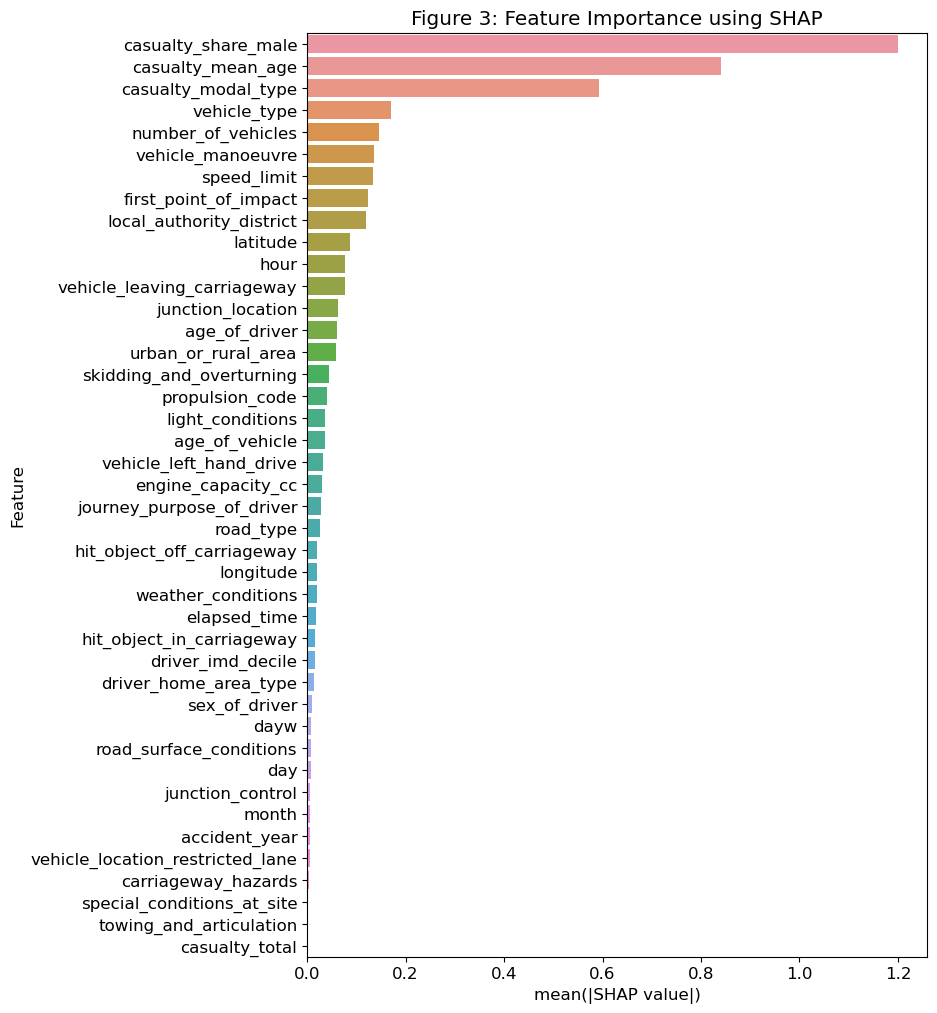

In [27]:
plt.figure(figsize=(8,12))
sns.barplot(most_important, x=0, y='index')
plt.ylabel('Feature')
plt.xlabel('mean(|SHAP value|)')
plt.title("Figure 3: Feature Importance using SHAP")
plt.show()

#### Feature importance according to LGBM's `plot_importance`

We obtain a very similar ordering of the most important features using LGBM's built-in `plot_importance` method. Importantly, feature importance according to SHAP values parallel LGBM's own feature importance only when we calculate importance according to "gain" (i.e. total gains of splits) rather than the default, "splits" (i.e. total number of times this feature used in the model).

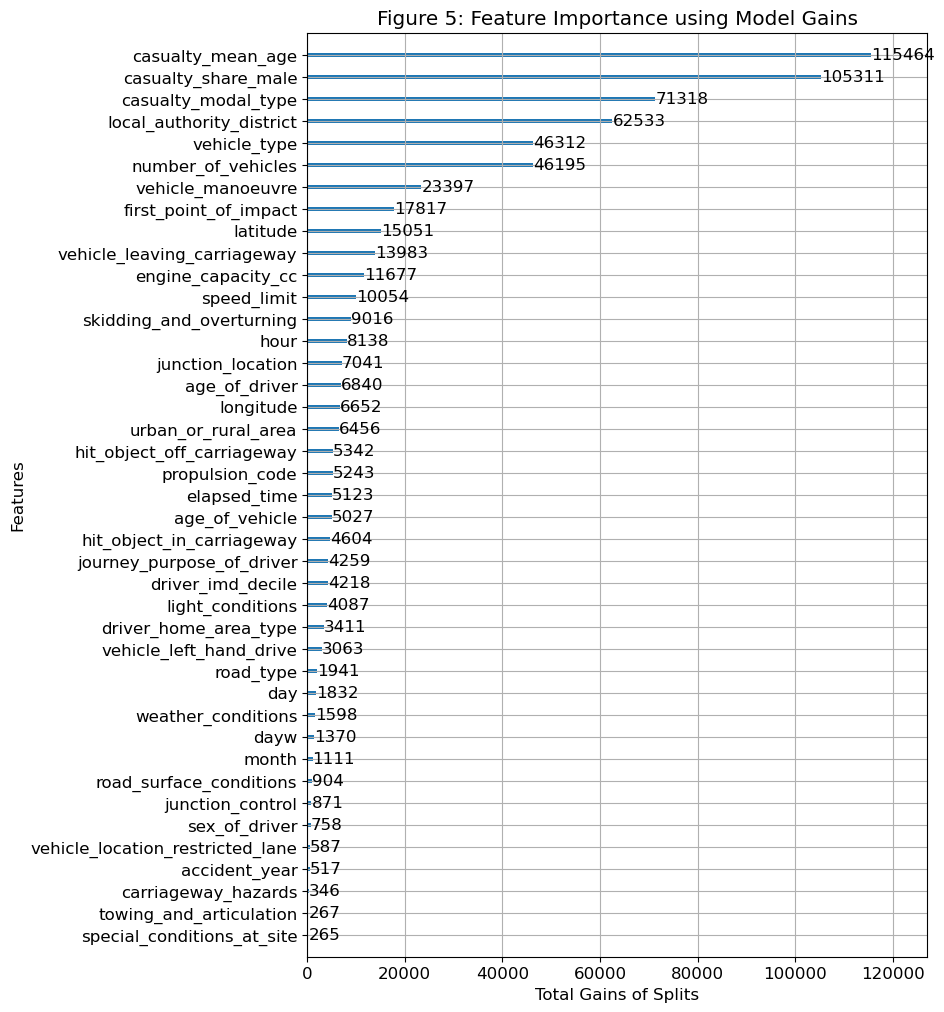

In [28]:
lgb.plot_importance(bst, figsize=(8,12), importance_type='gain', xlabel='Total Gains of Splits',
                    precision=0, title="Figure 5: Feature Importance using Model Gains")
plt.show()